# 0. Installing Dependencies & Import Libraries

In [2]:
!pip install tensorflow
!pip install keras
!pip install gym
!pip install gymnasium
!pip install keras-rl2
!pip install stable-baselines3
!pip install traci

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for tensorflow



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached keras_rl2-1.0.5-py3-none-any.whl.metadata (304 bytes)
INFO: pip is looking at multiple versions of keras-rl2 to determine which version is compatible with other requirements. This could take a while.
  Using cached keras_rl2-1.0.4-py3-none-any.whl.metadata (353 bytes)
  Using cached keras-rl2-1.0.3.tar.gz (40 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached keras-rl2-1.0.2.tar.gz (40 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject

ERROR: Cannot install keras-rl2==1.0.0, keras-rl2==1.0.1, keras-rl2==1.0.2, keras-rl2==1.0.3, keras-rl2==1.0.4 and keras-rl2==1.0.5 because these package versions have conflicting dependencies.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import random
import gymnasium
import sumolib
import time
import traci

# 1. OpenAI Gymnasium Environment

In [4]:
class SumoEnv(gymnasium.Env):
  def __init__(self, use_gui=False, use_random=False, use_actions=True, spawn_rate=0.5):
    super().__init__() # Initializes the parent class

    # Check if TraCI is already loaded; if so, close it
    if traci.isLoaded():
      traci.close()

    # Define the Discrete action space with gymnasium.spaces.Discrete(n)
    # choices are up & down = green, or l & r = green
    self.action_space = gymnasium.spaces.Discrete(4)

    # Define the Box observation space with gymnasium.spaces.Box()
    # Note the structure of the Box parameters requires NumPy arrays!
    # Define lanes directly connected to the intersection
    self.lanes = {
      # Edge 1 (East incoming)
      "4976399#0_0": {"type": [0, 1, 0], "phases": [0]},  # Stright lane
      "4976399#0_1": {"type": [1 ,0, 0], "phases": [0, 1, 2] },  #left lane    

      # Edge 2 (West incoming)
      "28160914#0_0": {"type": [0, 1, 1], "phases": [0]}, 
      "28160914#0_1": {"type": [1, 0, 0], "phases": [0,1,2]}, 
      
      # Edge 3 (South incoming)
      "4754858#0_0": {"type": [1, 1, 1], "phases": [4]},  # Left-Right-Straight-turn lane

      # Edge 4 (North incoming)
      "-388930252#1_0": {"type": [1, 1, 1], "phases": [4]},  # Left-turn lane
      
    }
    self.last_phase_change_time = { # note: each of the keys correspond to one of my end state phases
      0: 0,
      1: 0,
      2: 0,
      4: 0

    }
    self.vehicle_emissions = {}
    self.max_wait_time = 1000
    num_lanes=6
    num_metrics_per_lane = 5
    num_lane_type_features=3 # [left, straight, right] "one-hot" encoding
    observation_size = 2 + num_lanes * (num_metrics_per_lane + num_lane_type_features)
    
    max_cars = 100 # CHANGE FOR ACTUAL MAX. NUMBER OF CARS
    self.max_cars = max_cars
    
    self.car_spawn_rate = spawn_rate # cars spawn at 30% chance

    # np array structure: [traffic_light_phase][positions][speeds], dtype=np.float32
    self.observation_space = gymnasium.spaces.Box(
      low=np.array([0.0] * observation_size),
      high=np.array([1.0] * observation_size), # MUST CHANGE THE TRAFFIC LIGHT PHASE VALUE TO YOUR RESPECTIVE MAX!
      dtype=np.float32
    )
    
    # Upon each render of the SumoEnv Class, we should start the simulation
    # Implement the sumo_binary, sumo_config, and traci.start from test_demo.py
    self.use_gui = use_gui
    if use_gui:
      sumo_binary = sumolib.checkBinary('sumo-gui')
    else:
      sumo_binary = sumolib.checkBinary('sumo')

    # use the proper .sumocfg file depending on if want predefined or random cars
    self.use_random = use_random
    if use_random:
      sumo_config = "./network/queens.sumocfg"
    else:
      sumo_config = "./network/queens.sumocfg"
    
    # used to track number of deployed cars
    if self.use_random:
      self.deployed_counter = 0
    else:
      self.deployed_counter = 1

    # store these variables for use later
    self.sumo_binary = sumo_binary
    self.sumo_config = sumo_config

    # Start the simulation
    self.started = False

    # Track cumulative metrics
    self.vehicle_wait_log = {}
    self.total_congestion_log = []
    self.total_speed_log = []

    # use actions argument: False = use the timer based system instead (for comparing between agent and real-life)
    self.use_actions = use_actions

    # Define consistent pause time for sumo-gui visualization
    self.pause_time = 0.35

  def step(self, action):
    # On first step, start the traci sim
    if not self.started:
      traci.start([self.sumo_binary, "--start", "-c", self.sumo_config], port =3001)
      self.started = True
      traffic_light_id = traci.trafficlight.getIDList()[0] # MAKE SURE TO MODIFY IF YOUR INTERSECTION CONTAINS >1 TRAFFIC LIGHT
      traci.trafficlight.setPhase(traffic_light_id, 0)
          # Ensure light phases are all manually controlled

      if self.use_actions:
        traci.trafficlight.setPhaseDuration(traffic_light_id, 99999)  # Hold this phase indefinitely
    
    # Perform the action
    if self.use_actions:
      self.perform_action(action)
    
    # Spawn in a car if suits the spawn rate on step
    if self.use_random:
      if (random.random() < self.car_spawn_rate) and (self.deployed_counter < self.max_cars):
        self.spawn_random_car(self.deployed_counter)
        self.deployed_counter += 1

    # get the most updated vehicle emission for each vehicle in the simulation
    for vehicle_id in traci.vehicle.getIDList():
      if vehicle_id not in self.vehicle_emissions:
        self.vehicle_emissions[vehicle_id] = 0
      self.vehicle_emissions[vehicle_id] = traci.vehicle.getCO2Emission(vehicle_id)
  

    # Advance the simulation by one step
    traci.simulationStep()
    if self.use_gui: # pause in between steps to slow down if in 'simulation mode'
      time.sleep(self.pause_time) 
    #print("Step: " + str(traci.simulation.getTime()))
    # Get the new state
    observation = self.get_state()

    # Calculate the reward
    reward = self.calculate_reward()

    # Determine if simulation is done
    done = self.is_done()

    # Set placeholder for info -> returns the tracked cumulative metrics IF done
    info = {
      "vehicle_wait_log": self.vehicle_wait_log if done else None,
      "total_congestion_avg": (sum(self.total_congestion_log) / len(self.total_congestion_log)) if done and self.total_congestion_log else None,
      "total_speed_avg": (sum(self.total_speed_log) / len(self.total_speed_log)) if done and self.total_speed_log else None,
      "emissions": self.calculate_mean_emission()
    }

    # Set placeholder for truncated
    truncated = False

    # set 'observation' to a numpy array
    observation = np.array(observation, dtype=np.float32)

    # Return step information (MUST follow this order of variables!!!)
    return observation, reward, done, truncated, info

  def render(self):
    # render needs to exist in the Gymnasium env, as it is an essential aspect
    # however we might not need to put anything inside it, hence 'pass'
    # this depends on if the command -> traci.simulationStep() exists somewhere else in the Class
    pass

  def reset(self, seed=None, options=None):

    # resets the gymnasium.Env parent class
    super().reset(seed=seed)

    # close the simulation (reset)
    if not self.use_gui: # traci.load() doesn't work for sumo-gui - i.e. can only run once
      traci.load(["-c", self.sumo_config])

    # reset counter variables
    if self.use_random:
      self.deployed_counter = 0
    else:
      self.deployed_counter = 1

    # convert 'observation' to a NumPy array
    observation = np.array(self.get_state(), dtype=np.float32)

    self.last_phase_change_time = { # note: each of the keys correspond to one of my end state phases
      0: 0,
      1: 0,
      2: 0,
      4: 0
    }

    self.vehicle_emissions = {}
    self.vehicle_wait_log = {}
    self.total_congestion_log = []
    self.total_speed_log = []

    # return 'observation' and 'info' --> MUST be in this form
    return observation, {}


  def get_state(self):
    # Define a speed threshold for "stopped" vehicles
    speed_threshold = 0.1  # Vehicles with speed < 0.1 m/s are considered stopped

    state = []

    # 1. Traffic light phase (normalized to [0, 1])
    traffic_light_phase = traci.trafficlight.getPhase(traci.trafficlight.getIDList()[0])
    state.append(traffic_light_phase / 5.0)  # Normalize phase to [0, 1]
    for phase_change_time in self.last_phase_change_time:
      if phase_change_time == traffic_light_phase:
        self.last_phase_change_time[phase_change_time] = 0
      else:
        self.last_phase_change_time[phase_change_time] += 1

    # 2. Time since last phase change (normalized to [0, 1])
    current_time = traci.simulation.getTime()
    time_since_last_change = current_time - min(self.last_phase_change_time.values())
    state.append(time_since_last_change / self.max_wait_time)  # Normalize using max_wait_time

    # 3. Per-lane metrics (only for lanes directly connected to the intersection)
    for lane_id, lane_info in self.lanes.items():
        vehicle_ids = traci.lane.getLastStepVehicleIDs(lane_id)

        # Number of vehicles (normalized to [0, 1])
        num_vehicles = len(vehicle_ids)
        state.append(num_vehicles / self.max_cars)

        # Queue length (number of vehicles with speed < threshold, normalized to [0, 1])
        queue_length = sum(1 for v_id in vehicle_ids if traci.vehicle.getSpeed(v_id) < speed_threshold)
        state.append(queue_length / self.max_cars)

        # Total wait time (normalized to [0, 1])
        total_wait_time = sum(traci.vehicle.getWaitingTime(v_id) for v_id in vehicle_ids)
        state.append(total_wait_time / self.max_wait_time)  # Normalize using max_wait_time

        # Average speed (normalized to [0, 1])
        avg_speed = np.mean([traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids]) if vehicle_ids else 0
        state.append(avg_speed / traci.lane.getMaxSpeed(lane_id))  # Normalize to [0, 1]

        # Time since last visited  
        minn = float("inf")
        for phase in lane_info["phases"]:
          if self.last_phase_change_time[phase] < minn:
            minn = self.last_phase_change_time[phase]
        state.append(minn / float(max(self.last_phase_change_time.values())))

        # Lane type (one-hot encoded)
        lane_type = lane_info["type"]
        state.extend(lane_type)

    return np.array(state, dtype=np.float32)

  def perform_action(self, action):


    light_id = traci.trafficlight.getIDList()[0]
    current_phase = traci.trafficlight.getPhase(light_id)
    """
    Phases: 
      (0) E & W = all green, N & S = red
      Duration: 38 seconds (default)
      (1) E & W = yellow and left turn lanes are green with no priority, N & S = red
      Duration: 3 seconds (default)
      (2) E & W = red and left turn lanes are green with priority, N & S = red
      Duration: 6 seconds (default)
      (3) E & W = red and left turns are yellow, N & S = red
      Duration: 3 seconds (default)
      (4) E & W = red, N & S green, left turns are green
      Duration: 37 seconds (default)
      (5) E & W = red, N & S = yellow, left turns are yellow
    Duration: 3 seconds (default) 

    action == 0 : switching to green E & W ALL
    action == 1 : switching to green E & W left turn advance
    action == 2 : switching to green N & S left turn advance
    action == 3 : switching to green N & S ALL
    """
    
      # Action 0: Switch to Green E&W (ALL)
    if action == 0 and current_phase != 0:
        traci.trafficlight.setPhase(light_id, 3)  # Transition to yellow
        traci.trafficlight.setPhaseDuration(light_id, 3)  # Hold yellow for 3 seconds
        self.skip_steps(3)  # Pause to allow transition
        traci.trafficlight.setPhase(light_id, 0)  # Set E&W green
        traci.trafficlight.setPhaseDuration(light_id, 99999)  # Hold green indefinitely
        self.skip_steps(15)  # Ensure green is stable for at least 5 seconds

    # Action 1: Switch to Green E&W Left Turn Advance
    elif action == 1 and current_phase != 2:
        traci.trafficlight.setPhase(light_id, 1)  # Transition to yellow
        traci.trafficlight.setPhaseDuration(light_id, 3)  # Hold yellow for 3 seconds
        self.skip_steps(3)
        traci.trafficlight.setPhase(light_id, 2)  # Set E&W Left Turn Green
        traci.trafficlight.setPhaseDuration(light_id, 99999)  # Hold green indefinitely
        self.skip_steps(15)  # Ensure left turn phase is stable

    # Action 2: Switch to Green N&S Left Turn Advance
    elif action == 2 and current_phase != 4:
        traci.trafficlight.setPhase(light_id, 5)  # Transition to yellow
        traci.trafficlight.setPhaseDuration(light_id, 3)
        self.skip_steps(3)
        traci.trafficlight.setPhase(light_id, 4)  # Set N&S Green
        traci.trafficlight.setPhaseDuration(light_id, 99999)
        self.skip_steps(15)  # Ensure green stays long enough

    # Action 3: Switch to Green N&S ALL
    elif action == 3 and current_phase != 4:
        traci.trafficlight.setPhase(light_id, 5)  # Transition to yellow
        traci.trafficlight.setPhaseDuration(light_id, 3)
        self.skip_steps(3)
        traci.trafficlight.setPhase(light_id, 4)  # Set N&S all green
        traci.trafficlight.setPhaseDuration(light_id, 99999)
        self.skip_steps(15)  # Ensure green stays long enou
  

  def calculate_reward(self):
    # REWARD FUNCTION: Calculate the reward (should be negative if in a poor state i.e. high congestion)
    lane_ids = self.lanes.keys()
    vehicle_ids = traci.vehicle.getIDList()
    light_id = traci.trafficlight.getIDList()[0]
    current_phase = traci.trafficlight.getPhase(light_id)
    reward = 0
    try:

      for lane in self.lanes.keys():
        if current_phase in self.lanes[lane]["phases"]:
          reward += len(traci.lane.getLastStepVehicleIDs(lane))

        else:
          cur_wait_time = traci.lane.getWaitingTime(lane)
          cur_phases = self.lanes[lane]["phases"]
          min_phase = cur_phases[0]
          for j in range(1, len(cur_phases)):
            if self.last_phase_change_time[cur_phases[j]] < self.last_phase_change_time[min_phase]:
              min_phase = cur_phases[j]
          reward -= cur_wait_time * (self.last_phase_change_time[min_phase] / max(self.last_phase_change_time.values()))

      congestion = self.calculate_congestion(vehicle_ids)
      wait_time = self.calculate_avg_wait_time(lane_ids)
      stops = self.calculate_total_stops(lane_ids)
      avg_speed = self.calculate_avg_speed(vehicle_ids)# -> would be maximize so don't multiply by -1
      #reward = -1*(0.5*congestion + 0.8*wait_time + stops) + 0.75*avg_speed # minimize all terms

    except:

      print("BIG NONO")
      reward = 0

    return reward

  def skip_steps(self, x):
    for _ in range(x): 
      if self.use_random:
        if (random.random() < self.car_spawn_rate) and (self.deployed_counter < self.max_cars):
          self.spawn_random_car(self.deployed_counter)
          self.deployed_counter += 1
    

      # Advance the simulation by one step
      traci.simulationStep()
      if self.use_gui: # pause in between steps to slow down if in 'simulation mode'
        time.sleep(self.pause_time)

  def is_done(self):
    max_time = self.max_wait_time  # Example maximum simulation time
    return (traci.simulation.getTime() >= max_time or len(traci.vehicle.getIDList()) == 0) and self.deployed_counter >= self.max_cars -1


  # METRICS:
  def calculate_congestion(self, vehicle_ids):
    congestion = 0
    current_time = traci.simulation.getTime()  # Get the current simulation time
    
    for vehicle_id in vehicle_ids:
      departure_time = traci.vehicle.getDeparture(vehicle_id)  # Get each vehicle's departure time
      speed = traci.vehicle.getSpeed(vehicle_id)  # Get the vehicle's current speed
      
      # Check if the vehicle is stopped and not just starting/departing
      if speed == 0 and current_time not in range(int(departure_time) - 1, int(departure_time) + 2):
          congestion += 1  # Increment congestion counter for stopped vehicles
  
    # update congestion log
    self.total_congestion_log.append(congestion)

    return congestion

  def calculate_mean_emission(self):
    total_emissions = sum(self.vehicle_emissions.values())
    num_vehicles = len(self.vehicle_emissions)
    try:
        return total_emissions / num_vehicles
    except:
        return 0

  def calculate_avg_wait_time(self, lane_ids):
    wait_times = []
    
    # total wait time of cars in all lanes
    for lane_id in lane_ids:
      # total wait time of all cars in one lane
      for vehicle_id in traci.lane.getLastStepVehicleIDs(lane_id):
          wait_time = traci.vehicle.getWaitingTime(vehicle_id)

          # update the wait log
          if vehicle_id in self.vehicle_wait_log:
            self.vehicle_wait_log[vehicle_id] = max(self.vehicle_wait_log[vehicle_id], wait_time) # only want the greatest average wait time for each vehicle
          else:
            self.vehicle_wait_log[vehicle_id] = wait_time

          wait_times.append(wait_time)
  
    avg_wait_time = sum(wait_times)/len(wait_times) if wait_times else 0
    
    return avg_wait_time

  def calculate_total_stops(self, lane_ids):
    total_stops = 0
    for lane_id in lane_ids:
      stops_in_lane = traci.lane.getLastStepHaltingNumber(lane_id)
      total_stops += stops_in_lane

    return total_stops
    
  def calculate_avg_speed(self, vehicle_ids):
    total_speed = sum(traci.vehicle.getSpeed(v_id) for v_id in vehicle_ids)
    avg_speed = total_speed / len(vehicle_ids) if vehicle_ids else 0

    # update total speed log
    self.total_speed_log.append(avg_speed)

    return avg_speed

  def spawn_random_car(self, step_counter):
    """
    Spawns a random car with a unique ID and assigns it a random route.
    edge_mapping represents the available routes that any car can take; start_edge:end_edge
    """
    edge_mapping = {
        "-1152545423": ["28160916#0", "-4754858#0", "-462406637#0"], # North Starting
        "-28160916#3": ["-4754858#0", "-462406637#0", "1152545423"], # East starting
        "4754858#0": ["-462406637#0", "1152545423", "28160916#0"], # South starting 
        "462406637#0": ["-4754858#0", "28160916#0", "1152545423"] # West starting
    }
    vehicle_id = f"rand_car_{step_counter}"

    start_edge = random.choice(list(edge_mapping.keys()))
    end_edge = random.choice(edge_mapping[start_edge])

    route_id = f"route_{vehicle_id}"

    try:
        traci.route.add(routeID=route_id, edges=[start_edge, end_edge])

        # Add the vehicle to the simulation
        traci.vehicle.add(vehID=vehicle_id, routeID=route_id)

        #print(f"Deployed random vehicle {vehicle_id} from {start_edge} to {end_edge}")

        # Set a random speed for the vehicle
        traci.vehicle.setSpeed(vehicle_id, random.uniform(5, 15))

    except traci.TraCIException as e:
        pass
        #print(f"Failed to add vehicle {vehicle_id} on route from {start_edge} to {end_edge}: {e}")


### Simulation with SUMO-GUI

In [28]:
'''
    The purpose of this is just to visualize our results!
    Explanation of SumoEnv parameters:
        use_gui = True runs with sumo gui
        use_gui = False runs sumo (all same functionality just doesn't render anything)
        use_random = False tells the env NOT to deploy random vehicles
        use_random = True tells the env to deploy random vehicles
        use_actions = False tells the env that we are running with random actions (note can ONLY use False here since we are using env.action_space.sample() later)
        use_actions = True tell the env that we are running with actions chosen by the agent (will NOT work yet since we don't have an agent!)
'''

env = SumoEnv(use_gui=False, use_random=True, use_actions=True) # use_gui=False sets sumo_binary to 'sumo' instead of 'sumo-gui'

episodes = 1 # note can only be run ONCE with sumo-gui!
score_log = []
wait_log = []
emissions_log = []
congestion_log = []
speed_log = []

for episode in range(1, episodes + 1):
    done = False
    truncated = False
    score = 0
    info = {}

    while not done:
        env.render()
        action = env.action_space.sample()
        state, reward, done, truncated, info = env.step(action)
        score += reward


    state, _ = env.reset()
    score_log.append(score)


    # Extract wait time metrics
    emissions_log.append(info["emissions"])
    wait_times = info.get("vehicle_wait_log", {}).values()
    total_wait_time = sum(wait_times)
    num_cars = len(wait_times)
    episode_mean_wait = total_wait_time / num_cars if num_cars > 0 else 0
    wait_log.append(episode_mean_wait)

    # Extract congestion and speed metrics
    if info.get("total_congestion_avg") is not None:
        congestion_log.append(info["total_congestion_avg"])
    if info.get("total_speed_avg") is not None:
        speed_log.append(info["total_speed_avg"])

traci.close()

# Compute and print final metrics
mean_sample_score = np.mean(score_log)
mean_wait_time = np.mean(wait_log)
mean_congestion = np.mean(congestion_log) if congestion_log else None
mean_speed = np.mean(speed_log) if speed_log else None
mean_emissions = np.mean(emissions_log) if emissions_log else None

print(f"Mean Score over {episodes} episodes: {mean_sample_score}")
print(f"Mean wait time over {episodes} episodes: {mean_wait_time}")
print(f"Mean congestion over {episodes} episodes: {mean_congestion}")
print(f"Mean speed over {episodes} episodes: {mean_speed}")
print(f"Mean emissions over {episodes} episodes: {mean_emissions} milligrams (mg)")


Mean Score over 1 episodes: -626.5509527724932
Mean wait time over 1 episodes: 25.093023255813954
Mean congestion over 1 episodes: 6.193548387096774
Mean speed over 1 episodes: 5.1779428371131715
Mean emissions over 1 episodes: 2183.7238874223303 milligrams (mg)


In [15]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv

In [39]:
# CREATE NEW VEC ENV
env = SumoEnv(use_gui=False, use_random=True, use_actions=True)
env.step(0)
#check_env(env)
env = DummyVecEnv([lambda: env])

In [1]:
# TRAIN AGENT
env = SumoEnv(use_gui=False, use_random=True, use_actions=True)
env.step(0)
#check_env(env)
env = DummyVecEnv([lambda: env])
model = PPO("MlpPolicy", env, verbose=1)

spawn_rates = np.arange(0.05, 0.9, 0.05) 

for spawn_rate in spawn_rates:
    env = SumoEnv(use_gui=False, use_random=True, use_actions=True, spawn_rate=spawn_rate)
    env.step(0)
    env = DummyVecEnv([lambda: env])

    model.set_env(env)

    model.learn(total_timesteps=30000)


# can change number of timesteps, however at least 10000 to make a semi-decent one
model.save("./agents/mcmaster-agent-various-rates-3") # takes ~30 mins 

NameError: name 'SumoEnv' is not defined

In [40]:
# SAVE THE MODEL
model.save("./agents/mcmaster-agent-fixed2") # creates .zip in current working directory

In [41]:
loaded_model = PPO.load("./agents/mcmaster-agent-various-rates-3")

In [42]:
# CREATE VEC ENV
env = SumoEnv(use_gui=False, use_random=True, use_actions=True, spawn_rate=0.50)
env.step(0)
#check_env(env)
env = DummyVecEnv([lambda: env])

In [43]:
# RUN TEST EPISODES
num_test_episodes = 25
all_scores = []
wait_log = []
emissions_log = []
# Run multiple test episodes
for episode in range(num_test_episodes):
    obs = env.reset()
    done = False
    episode_score = 0
    info = {}
    while not done:
        action, _states = loaded_model.predict(obs, deterministic=True)  # Use deterministic actions during testing
        obs, reward, done, info = env.step(action)
        episode_score += reward

    all_scores.append(episode_score)

    print(info)
    emissions_log.append(info[0].get("emissions"))
    wait_times = info[0].get('vehicle_wait_log', {}).values()
    total_wait_time = sum(wait_times)
    num_cars = len(wait_times)
    episode_mean_wait = total_wait_time / num_cars
    wait_log.append(episode_mean_wait)

traci.close()
mean_score = np.mean(all_scores)
mean_emissions = np.mean(emissions_log) if emissions_log else None
print(f"Mean Score over {num_test_episodes} episodes: {mean_score}")
print(f"Mean wait time over {num_test_episodes} episodes: {np.mean(wait_log)}")
print(f"Mean emissions over {num_test_episodes} episodes: {mean_emissions} milligrams (mg)")
print(wait_log)

[{'vehicle_wait_log': {'rand_car_3': 10.0, 'rand_car_14': 10.0, 'rand_car_7': 0.0, 'rand_car_6': 3.0, 'rand_car_5': 4.0, 'rand_car_4': 12.0, 'rand_car_9': 9.0, 'rand_car_8': 11.0, 'rand_car_26': 0.0, 'rand_car_19': 11.0, 'rand_car_18': 12.0, 'rand_car_16': 16.0, 'rand_car_15': 17.0, 'rand_car_12': 18.0, 'rand_car_11': 12.0, 'rand_car_25': 3.0, 'rand_car_21': 10.0, 'rand_car_29': 0.0, 'rand_car_17': 8.0, 'rand_car_24': 3.0, 'rand_car_13': 12.0, 'rand_car_23': 6.0, 'rand_car_22': 10.0, 'rand_car_27': 0.0, 'rand_car_38': 0.0, 'rand_car_37': 0.0, 'rand_car_34': 8.0, 'rand_car_33': 12.0, 'rand_car_30': 13.0, 'rand_car_52': 5.0, 'rand_car_45': 0.0, 'rand_car_44': 0.0, 'rand_car_41': 0.0, 'rand_car_40': 0.0, 'rand_car_39': 0.0, 'rand_car_32': 0.0, 'rand_car_31': 13.0, 'rand_car_49': 1.0, 'rand_car_48': 2.0, 'rand_car_47': 3.0, 'rand_car_43': 5.0, 'rand_car_46': 4.0, 'rand_car_56': 0.0, 'rand_car_51': 0.0, 'rand_car_42': 0.0, 'rand_car_53': 19.0, 'rand_car_61': 6.0, 'rand_car_60': 0.0, 'rand_c

Beginning spawn rate = 0.05
[np.float64(32.367816091954026), np.float64(23.01086956521739), np.float64(28.310344827586206), np.float64(39.61363636363637), np.float64(30.775280898876403), np.float64(26.166666666666668), np.float64(32.630434782608695), np.float64(27.641304347826086), np.float64(33.06741573033708), np.float64(23.272727272727273), np.float64(41.69318181818182), np.float64(24.181818181818183), np.float64(33.64835164835165), np.float64(34.04255319148936), np.float64(30.310344827586206), np.float64(30.164835164835164), np.float64(33.70238095238095), np.float64(29.136363636363637), np.float64(35.01149425287356), np.float64(42.96629213483146), np.float64(24.75824175824176), np.float64(23.78409090909091), np.float64(37.68478260869565), np.float64(28.16304347826087), np.float64(23.54945054945055), np.float64(35.28089887640449), np.float64(26.875), np.float64(34.83516483516483), np.float64(24.51685393258427), np.float64(29.967391304347824), np.float64(28.08235294117647), np.float6

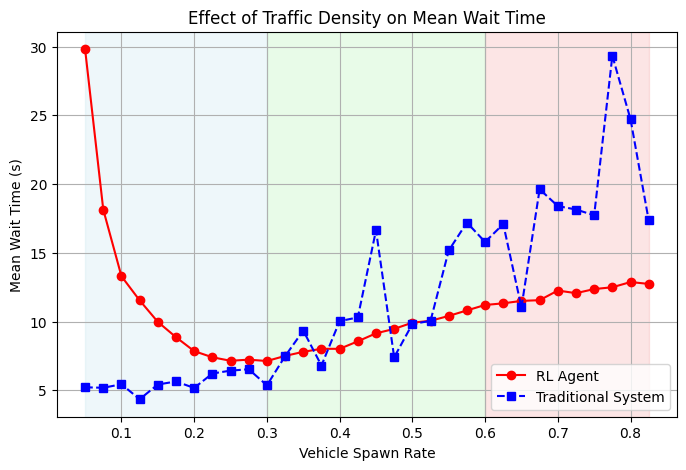

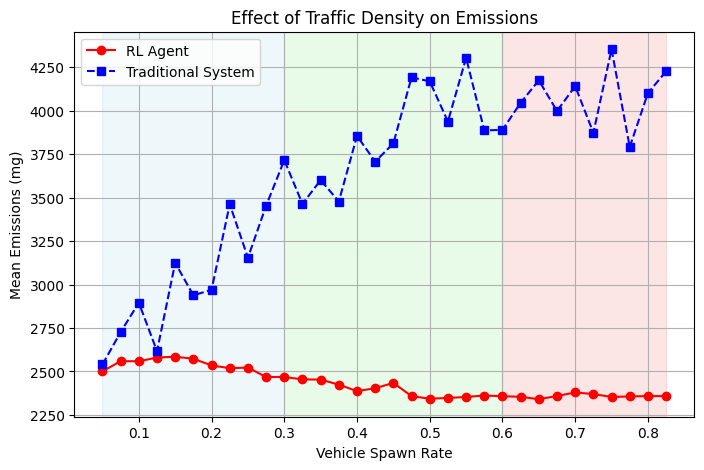

In [44]:
import numpy as np
import matplotlib.pyplot as plt

spawn_rates = np.arange(0.05, 0.85, 0.025)  # Adjust range as needed

# Initialize logs
mean_wait_times_rl = []
mean_emissions_rl = []
mean_wait_times_random = []
mean_emissions_random = []

num_test_episodes = 100  # Keep both cases consistent

for spawn_rate in spawn_rates:
    print("Beginning spawn rate =", spawn_rate)
    # ============================== RL Agent ====================================
    env_rl = SumoEnv(use_gui=False, use_random=True, use_actions=True, spawn_rate=spawn_rate)
    env_rl.step(0)
    env_rl = DummyVecEnv([lambda: env_rl])

    all_wait_times_rl = []  # Collect mean wait time for each episode
    all_emissions_rl = []   # Collect emissions for each episode

    for episode in range(num_test_episodes):
        obs = env_rl.reset()
        done = False
        info = {}

        while not done:
            action, _states = loaded_model.predict(obs, deterministic=True)
            obs, reward, done, info = env_rl.step(action)

        # Collect RL agent data
        if "emissions" in info[0]:
            all_emissions_rl.append(info[0]["emissions"])
        if "vehicle_wait_log" in info[0]:
            wait_times = list(info[0]["vehicle_wait_log"].values())
            episode_mean_wait = np.mean(wait_times) if wait_times else 0  # Calculate mean for this episode
            all_wait_times_rl.append(episode_mean_wait)  # Store mean for this episode

    traci.close()

    print(all_wait_times_rl)
    
    # Store RL results
    mean_wait_time_rl = np.mean(all_wait_times_rl)  # Mean of episode means
    mean_emission_rl = np.mean(all_emissions_rl) if all_emissions_rl else 0

    print("RL: spawn_rate=", spawn_rate, "wait time mean=", mean_wait_time_rl)
    print("Wait log length RL:", len(all_wait_times_rl))
    mean_wait_times_rl.append(mean_wait_time_rl)
    mean_emissions_rl.append(mean_emission_rl)

    # ============================== Random Actions ====================================
    env_random = SumoEnv(use_gui=False, use_random=True, use_actions=False, spawn_rate=spawn_rate)

    all_wait_times_random = []  # Collect mean wait time for each episode
    all_emissions_random = []   # Collect emissions for each episode

    for episode in range(num_test_episodes):
        done = False
        info = {}

        while not done:
            action = env_random.action_space.sample()  # Random actions
            state, reward, done, truncated, info = env_random.step(action)

        # Collect Random actions data
        if "emissions" in info:
            all_emissions_random.append(info["emissions"])
        if "vehicle_wait_log" in info:
            wait_times = list(info["vehicle_wait_log"].values())
            episode_mean_wait = np.mean(wait_times) if wait_times else 0  # Calculate mean for this episode
            all_wait_times_random.append(episode_mean_wait)  # Store mean for this episode

    traci.close()

    # Store Random results
    mean_wait_time_random = np.mean(all_wait_times_random)  # Mean of episode means
    mean_emission_random = np.mean(all_emissions_random) if all_emissions_random else 0

    print("Random actions: spawn_rate=", spawn_rate, "wait time mean=", mean_wait_time_random)
    print("Random actions wait log length: ", len(all_wait_times_random))
    mean_wait_times_random.append(mean_wait_time_random)
    mean_emissions_random.append(mean_emission_random)

# ============================== Plot Results ====================================

# Define traffic density boundaries
low_traffic_end = 0.3
high_traffic_start = 0.6

# Colors for different traffic densities
low_color = "lightblue"
medium_color = "lightgreen"
high_color = "lightcoral"

# ========================= Mean Wait Time Plot =========================
plt.figure(figsize=(8, 5))

plt.axvspan(min(spawn_rates), low_traffic_end, color=low_color, alpha=0.2)
plt.axvspan(low_traffic_end, high_traffic_start, color=medium_color, alpha=0.2)
plt.axvspan(high_traffic_start, max(spawn_rates), color=high_color, alpha=0.2)


plt.plot(spawn_rates, mean_wait_times_rl, marker="o", color="red", label="RL Agent")
plt.plot(spawn_rates, mean_wait_times_random, marker="s", color="blue", linestyle="dashed", label="Traditional System")

plt.xlabel("Vehicle Spawn Rate")
plt.ylabel("Mean Wait Time (s)")
plt.title("Effect of Traffic Density on Mean Wait Time")
plt.grid(True)
plt.legend()

# Add text labels for traffic regions
#plt.text(0.05, max(mean_wait_times_rl) * 0.9, "Low Traffic", fontsize=12, color="black")
#plt.text(0.35, max(mean_wait_times_rl) * 0.9, "Medium Traffic", fontsize=12, color="black")
#plt.text(0.65, max(mean_wait_times_rl) * 0.9, "High Traffic", fontsize=12, color="black")

plt.savefig("mean_wait_time_plot_final2.png")
plt.show()

# ========================= Mean Emissions Plot =========================
plt.figure(figsize=(8, 5))

plt.axvspan(min(spawn_rates), low_traffic_end, color=low_color, alpha=0.2)
plt.axvspan(low_traffic_end, high_traffic_start, color=medium_color, alpha=0.2)
plt.axvspan(high_traffic_start, max(spawn_rates), color=high_color, alpha=0.2)


plt.plot(spawn_rates, mean_emissions_rl, marker="o", color="red", label="RL Agent")
plt.plot(spawn_rates, mean_emissions_random, marker="s", color="blue", linestyle="dashed", label="Traditional System")

plt.xlabel("Vehicle Spawn Rate")
plt.ylabel("Mean Emissions (mg)")
plt.title("Effect of Traffic Density on Emissions")
plt.grid(True)
plt.legend()

plt.savefig("mean_emissions_plot_final2.png")
plt.show()